# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Load and Clean data 

In [2]:
df = pd.read_csv("supermarket_sales.csv")
df.head()

,Order_ID,Order_Date,Region,Country,Sales_Rep,Team,Customer_ID,Customer_Segment,Product_Category,Product_Name,Stage,Units_Sold,Revenue,Target,Deal_Size
0,4971,2021-01-01,North,USA,David Lee,Team C,C3971,Corporate,Furniture,Office Chair,Won,6,1662,1447,1665
1,2347,2021-01-02,South,Brazil,Alice Johnson,Team B,C1347,SME,Appliances,Microwave Max,Opportunity,2,464,875,928
2,2588,2021-01-02,South,Brazil,Maria Garcia,Team C,C1588,Retail,Appliances,Refrigerator,Opportunity,5,132,277,264
3,5092,2021-01-02,East,China,Priya Sharma,Team B,C4092,Retail,Appliances,Microwave Max,Opportunity,5,610,1080,1220
4,1182,2021-01-02,North,Canada,David Lee,Team A,C0182,Retail,Electronics,Smartphone Z,Lost,0,0,854,0


In [3]:
df.info()
df.shape
df.isnull().sum()
df.drop_duplicates(inplace=True)
df.dtypes
df.describe()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Order_ID          5000 non-null   int64 
 1   Order_Date        5000 non-null   object
 2   Region            5000 non-null   object
 3   Country           5000 non-null   object
 4   Sales_Rep         5000 non-null   object
 5   Team              5000 non-null   object
 6   Customer_ID       5000 non-null   object
 7   Customer_Segment  5000 non-null   object
 8   Product_Category  5000 non-null   object
 9   Product_Name      5000 non-null   object
 10  Stage             5000 non-null   object
 11  Units_Sold        5000 non-null   int64 
 12  Revenue           5000 non-null   int64 
 13  Target            5000 non-null   int64 
 14  Deal_Size         5000 non-null   int64 
dtypes: int64(5), object(10)
memory usage: 586.1+ KB


np.int64(0)

In [4]:
df.columns

Index(['Order_ID', 'Order_Date', 'Region', 'Country', 'Sales_Rep', 'Team',
       'Customer_ID', 'Customer_Segment', 'Product_Category', 'Product_Name',
       'Stage', 'Units_Sold', 'Revenue', 'Target', 'Deal_Size'],
      dtype='object')

## Preprocessing

In [5]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce') 
df['Order_Date'].head()

0   2021-01-01
1   2021-01-02
2   2021-01-02
3   2021-01-02
4   2021-01-02
Name: Order_Date, dtype: datetime64[ns]

In [6]:
df['Order_Date'].tail()

4995   2024-12-29
4996   2024-12-30
4997   2024-12-30
4998   2024-12-30
4999   2024-12-30
Name: Order_Date, dtype: datetime64[ns]

In [7]:
df['Year'] = df['Order_Date'].dt.year
df['Month'] = df['Order_Date'].dt.month
df['Day'] = df['Order_Date'].dt.day
df['DayOfWeek'] = df['Order_Date'].dt.dayofweek
df['WeekOfYear'] = df['Order_Date'].dt.isocalendar().week

In [8]:
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x:1 if x>=5 else 0)
df.head()

,Order_ID,Order_Date,Region,Country,Sales_Rep,Team,Customer_ID,Customer_Segment,Product_Category,Product_Name,...,Units_Sold,Revenue,Target,Deal_Size,Year,Month,Day,DayOfWeek,WeekOfYear,IsWeekend
0,4971,2021-01-01,North,USA,David Lee,Team C,C3971,Corporate,Furniture,Office Chair,...,6,1662,1447,1665,2021,1,1,4,53,0
1,2347,2021-01-02,South,Brazil,Alice Johnson,Team B,C1347,SME,Appliances,Microwave Max,...,2,464,875,928,2021,1,2,5,53,1
2,2588,2021-01-02,South,Brazil,Maria Garcia,Team C,C1588,Retail,Appliances,Refrigerator,...,5,132,277,264,2021,1,2,5,53,1
3,5092,2021-01-02,East,China,Priya Sharma,Team B,C4092,Retail,Appliances,Microwave Max,...,5,610,1080,1220,2021,1,2,5,53,1
4,1182,2021-01-02,North,Canada,David Lee,Team A,C0182,Retail,Electronics,Smartphone Z,...,0,0,854,0,2021,1,2,5,53,1


In [9]:
df.tail()

,Order_ID,Order_Date,Region,Country,Sales_Rep,Team,Customer_ID,Customer_Segment,Product_Category,Product_Name,...,Units_Sold,Revenue,Target,Deal_Size,Year,Month,Day,DayOfWeek,WeekOfYear,IsWeekend
4995,1617,2024-12-29,West,Germany,Alice Johnson,Team B,C0617,Retail,Furniture,Standing Desk,...,1,489,724,979,2024,12,29,6,52,1
4996,2016,2024-12-30,North,Canada,Priya Sharma,Team A,C1016,Corporate,Furniture,Standing Desk,...,1,203,486,407,2024,12,30,0,1,0
4997,1903,2024-12-30,West,Germany,David Lee,Team B,C0903,Corporate,Furniture,Standing Desk,...,0,0,1424,0,2024,12,30,0,1,0
4998,2127,2024-12-30,West,Germany,David Lee,Team A,C1127,SME,Electronics,Smartphone Z,...,10,1170,1044,1172,2024,12,30,0,1,0
4999,4221,2024-12-30,South,Brazil,Wei Zhang,Team C,C3221,Corporate,Furniture,Standing Desk,...,0,0,1876,0,2024,12,30,0,1,0


### Adding the Promo Feature

In many real-world sales and retail datasets, promotional activities (such as discounts, special offers, seasonal sales, etc.) have a strong impact on product demand. When promotions occur, sales typically increase compared to normal days. 

To make our dataset more aligned with real-world forecasting scenarios, we introduce a **Promo** feature. Currently, our dataset does not contain explicit promotion information, so we initialize the column with a default value of `0`, which indicates *no promotion*. 

This column is added to:

1. **Keep the dataset structure flexible** – If promotion data becomes available later, we can easily fill or update this feature.
2. **Prepare the dataset for future model improvements** – Advanced forecasting models often use promotional indicators as key predictors.
3. **Maintain consistency with industry forecasting practices** – Promotion flags are widely used in sales prediction models.

**Note:** At this stage, the Promo column does not affect the model because all values are `0`, but it will be useful if promotion-related data is added in the future.

In [10]:
df['Promo'] = 0
df['Promo'] = df['Promo'].astype(int)
df.head()

,Order_ID,Order_Date,Region,Country,Sales_Rep,Team,Customer_ID,Customer_Segment,Product_Category,Product_Name,...,Revenue,Target,Deal_Size,Year,Month,Day,DayOfWeek,WeekOfYear,IsWeekend,Promo
0,4971,2021-01-01,North,USA,David Lee,Team C,C3971,Corporate,Furniture,Office Chair,...,1662,1447,1665,2021,1,1,4,53,0,0
1,2347,2021-01-02,South,Brazil,Alice Johnson,Team B,C1347,SME,Appliances,Microwave Max,...,464,875,928,2021,1,2,5,53,1,0
2,2588,2021-01-02,South,Brazil,Maria Garcia,Team C,C1588,Retail,Appliances,Refrigerator,...,132,277,264,2021,1,2,5,53,1,0
3,5092,2021-01-02,East,China,Priya Sharma,Team B,C4092,Retail,Appliances,Microwave Max,...,610,1080,1220,2021,1,2,5,53,1,0
4,1182,2021-01-02,North,Canada,David Lee,Team A,C0182,Retail,Electronics,Smartphone Z,...,0,854,0,2021,1,2,5,53,1,0


In [11]:
df = df.fillna(method='ffill')   
df = df.fillna(method='bfill')   
df.isnull().sum()

C:\Users\Hp\AppData\Local\Temp\ipykernel_5788\1094949500.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
C:\Users\Hp\AppData\Local\Temp\ipykernel_5788\1094949500.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


Order_ID            0
Order_Date          0
Region              0
Country             0
Sales_Rep           0
Team                0
Customer_ID         0
Customer_Segment    0
Product_Category    0
Product_Name        0
Stage               0
Units_Sold          0
Revenue             0
Target              0
Deal_Size           0
Year                0
Month               0
Day                 0
DayOfWeek           0
WeekOfYear          0
IsWeekend           0
Promo               0
dtype: int64

## Train Models

In [12]:
features = ['Units_Sold', 'Target', 'Deal_Size', 'Month', 'DayOfWeek', 'WeekOfYear', 'IsWeekend']
target = 'Revenue'

X = df[features]
y = df[target]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

The dataset is split into training and testing sets using train_test_split. 80% of the data is used to train the model, while 20% is held out for testing to evaluate how well the model performs on unseen data. The random_state=42 ensures reproducibility of the split.

## Linear Regression Model

In [14]:
# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)                           #X_train → used in .fit() and X_test → used in .predict() (for evaluation)

# Predict
y_pred_lr = lr_model.predict(X_test)                     #X_test contains new data the model did not see during training

# Evaluation
lr_mae = mean_absolute_error(y_test, y_pred_lr)          #y_test means actual revenue and y_pred_lr means predicted revenue
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print("MAE:", lr_mae)
print("RMSE:", lr_rmse)
print("R² Score:", lr_r2)

Linear Regression Performance:
MAE: 124.07382056460096
RMSE: 154.02045965534762
R² Score: 0.9203076421550632


## Random Forest Model

In [15]:
# Train the model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluation
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print("MAE:", rf_mae)
print("RMSE:", rf_rmse)
print("R² Score:", rf_r2)

Random Forest Performance:
MAE: 32.668585
RMSE: 82.73640233340461
R² Score: 0.9770039570678852


## XGBoost Model

In [16]:
#Train the model
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

xgb_model.fit(X_train, y_train)

#Predict
y_pred_xgb = xgb_model.predict(X_test)

#Evaluation
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost Performance:")
print("MAE:", xgb_mae)
print("RMSE:", xgb_rmse)
print("R² Score:", xgb_r2)

XGBoost Performance:
MAE: 39.231937408447266
RMSE: 89.74660236866212
R² Score: 0.9729419946670532


## Compare All Models

In [17]:
print("\nModel Comparison:")
print(f"Linear Regression -> RMSE: {lr_rmse:.2f}, R²: {lr_r2:.2f}, MAE: {lr_mae:.2f}")
print(f"Random Forest     -> RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}, MAE: {rf_mae:.2f}")
print(f"XGBoost           -> RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.2f}, MAE: {xgb_mae:.2f}")


Model Comparison:
Linear Regression -> RMSE: 154.02, R²: 0.92, MAE: 124.07
Random Forest     -> RMSE: 82.74, R²: 0.98, MAE: 32.67
XGBoost           -> RMSE: 89.75, R²: 0.97, MAE: 39.23


Model Performance Summary:

The Random Forest model achieved the best performance with the lowest RMSE (82.74) and the highest R² score (0.98). This indicates that it is able to explain 98% of the variance in Revenue and produces more accurate predictions compared to Linear Regression and XGBoost. The Linear Regression model performed well but struggled with complex relationships in the data, while XGBoost performed strongly but slightly below the Random Forest. Therefore, Random Forest is recommended for future sales forecasting and deployment.

## Time-Based Cross Validation (Walk-Forward)

In [18]:
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    rf_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = rf_model.predict(X_test_cv)

    rmse_cv = np.sqrt(mean_squared_error(y_test_cv, y_pred_cv))
    print(f"Fold {fold+1} RMSE:", rmse_cv)

Fold 1 RMSE: 92.64559206115176
Fold 2 RMSE: 87.01744790319832
Fold 3 RMSE: 83.88392411845194
Fold 4 RMSE: 82.58157194865089
Fold 5 RMSE: 79.3051259138934


We applied TimeSeriesSplit to validate the Random Forest model on time-ordered data. The RMSE scores decreased gradually across the folds (from 92.64 to 79.30). This indicates that the model improves as more historical data is included and is able to generalize well to future time periods. Therefore, Random Forest is not only the best-performing model but is also stable and reliable for forecasting sales.

## Feature Importance (Random Forest)

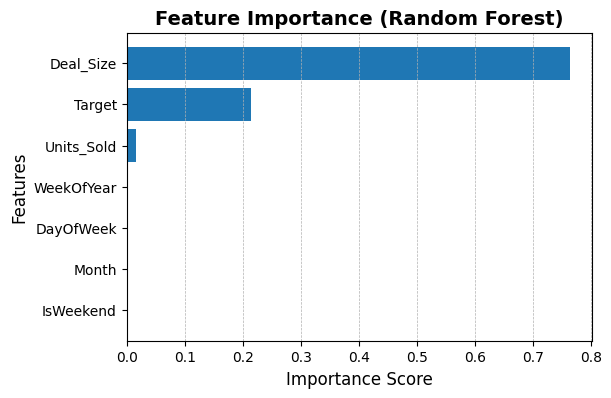

In [19]:
# Get feature importances
importances = rf_model.feature_importances_
features = X.columns

# Create a sorted order (largest importance first)
sorted_idx = importances.argsort()

plt.figure(figsize=(6,4))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance (Random Forest)", fontsize=14, weight='bold')
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.show()

## Residual Analysis

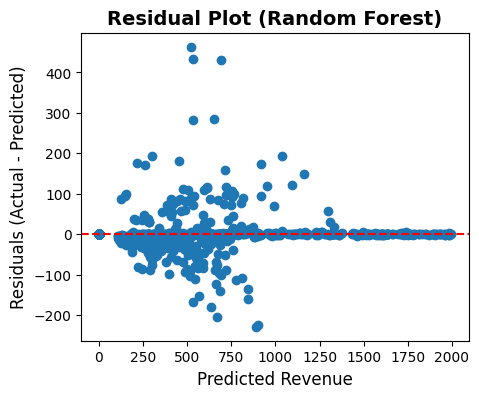

In [20]:
y_pred = rf_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(5,4))
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle='--', color = 'red')
plt.title("Residual Plot (Random Forest)", fontsize=14, weight='bold')
plt.xlabel("Predicted Revenue", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.show()

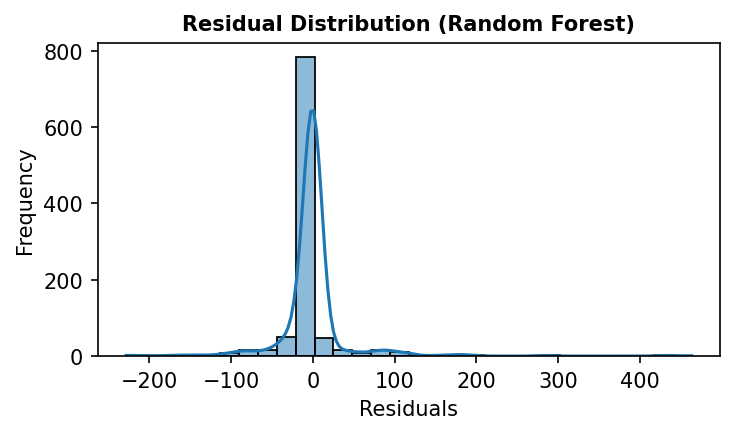

In [21]:
plt.figure(figsize=(5,3), dpi=150)   # Bigger graph + clearer resolution

sns.histplot(residuals, kde=True, bins=30)  # bins added for smooth funnel shape
plt.title("Residual Distribution (Random Forest)", fontsize=10, weight='bold')
plt.xlabel("Residuals", fontsize=10)
plt.ylabel("Frequency", fontsize=10)

plt.tight_layout()
plt.show()

In [22]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
monthly_data = df.groupby(df['Order_Date'].dt.to_period('M'))['Revenue'].sum().reset_index()
monthly_data['Order_Date'] = monthly_data['Order_Date'].dt.to_timestamp()
monthly_data.head()

,Order_Date,Revenue
0,2021-01-01,50030
1,2021-02-01,50128
2,2021-03-01,56178
3,2021-04-01,53854
4,2021-05-01,41046


In [23]:
monthly_data['Time_Index'] = range(len(monthly_data))

In [24]:
X = monthly_data[['Time_Index']]
y = monthly_data['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
future_months = 15 

last_index = monthly_data['Time_Index'].iloc[-1]
future_indexes = pd.DataFrame({'Time_Index': range(last_index+1, last_index+future_months+1)})

future_predictions = model.predict(future_indexes)

future_df = pd.DataFrame({
    'Order_Date': pd.date_range(start=monthly_data['Order_Date'].iloc[-1], periods=future_months+1, freq='M')[1:],
    'Predicted_Revenue': future_predictions
})

future_df

C:\Users\Hp\AppData\Local\Temp\ipykernel_5788\110587266.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Order_Date': pd.date_range(start=monthly_data['Order_Date'].iloc[-1], periods=future_months+1, freq='M')[1:],


,Order_Date,Predicted_Revenue
0,2025-01-31,58508.5
1,2025-02-28,58508.5
2,2025-03-31,58508.5
3,2025-04-30,58508.5
4,2025-05-31,58508.5
5,2025-06-30,58508.5
6,2025-07-31,58508.5
7,2025-08-31,58508.5
8,2025-09-30,58508.5
9,2025-10-31,58508.5


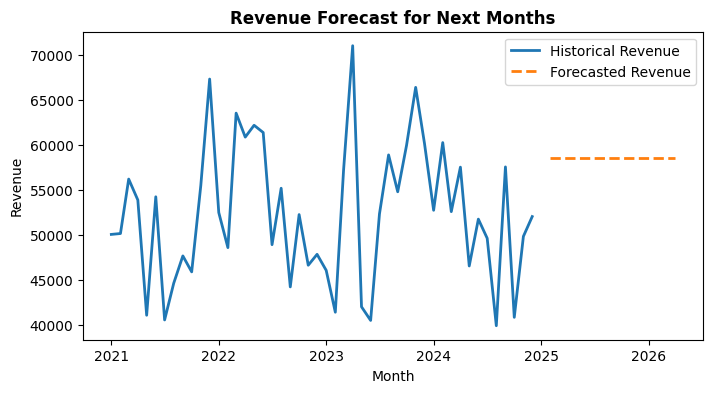

In [26]:
plt.figure(figsize=(8,4))
plt.plot(monthly_data['Order_Date'], monthly_data['Revenue'], label="Historical Revenue", linewidth=2)
plt.plot(future_df['Order_Date'], future_df['Predicted_Revenue'], label="Forecasted Revenue", linewidth=2, linestyle='dashed')
plt.title("Revenue Forecast for Next Months", weight='bold')
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.show()